# Accessing MUR 1-km Zarr from AWS Open Registry + Analysis

This notebook was developed following the workflow defined in Jack McNelis's "Co-locate satellite and in-situ data for cross-validation" notebook, located here: https://github.com/podaac/tutorials/blob/master/notebooks/SWOT-EA-2021/Colocate_satellite_insitu_ocean.ipynb

**Goal**
<br/>
To access the MUR 1-km dataset stored on AWS Open Registry and to use a subset of it for testing analysis speed.

**Run Location**
<br/>
This notebook was run on an Amazon Web Services (AWS) t3.small EC2, but can be run locally depending on available memory and processing power.

**Dataset**
<br/>
MUR 1-km L4 SST https://registry.opendata.aws/mur/

### Import Modules

In [1]:
import s3fs
import numpy as np
import xarray as xr
import fsspec
import zarr
from dask.distributed import Client

### Dataset URL
<br/>
We use this URL to reference the MUR 1-km L4 dataset on the AWS Open Registry.

In [2]:
URL = 's3://mur-sst/zarr'

### Period and Region of Interest

In [3]:
start_date = "2015-01-01"
end_date = "2015-01-31"

minlat = 18
maxlat = 25
minlon = -160
maxlon = -150

### Open Dataset
<br/>
Open the remote dataset from its S3 endpoint. The dataset is pre-consolidated, meaning the metadata is stored in a single, optimized resource. We can take advantage of this by declaring 'consolidated=True' which uses that resource to reduce the number of read operations when opening the data.
<br/>
<br/>
The original plan for this access was to find a way to take a subset of this dataset prior to loading it into Xarray with the assumption being made that it would be loaded into memory once ".open_zarr()" was called. It was later discovered that Xarray takes advantage of "lazy loading", meaning that the data is not  loaded into memory until it is required for an operation. It was also found that NetCDF4 and Zarr (among a few other data formats) support being sliced into a subset without loading the whole dataset into memory when being used with Xarray. This allows the access, subset, and analysis workflow to be relatively simple.

In [4]:
ds = xr.open_zarr(fsspec.get_mapper(URL, anon=True), consolidated=True)

In [5]:
ds

,Array,Chunk
Bytes,16.70 TB,257.72 MB
Shape,"(6443, 17999, 36000)","(6443, 100, 100)"
Count,64801 Tasks,64800 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,16.70 TB,257.72 MB
Shape,"(6443, 17999, 36000)","(6443, 100, 100)"
Count,64801 Tasks,64800 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


**Alternative Dataset Opening and Slicing**
<br/>
However, neither option seem to generate desired outcome faster than current approach.

In [6]:
# mur = zarr.open_consolidated(URL, storage_options={'anon': True})

**Or**

In [ ]:
# test = xr.open_dataset(fsspec.get_mapper(URL, anon=True), engine="zarr", cache=False)

In [41]:
# mur.tree()

Tree(nodes=(Node(disabled=True, name='/', nodes=(Node(disabled=True, icon='table', name='analysed_sst (6443, 1…

In [ ]:
# mur_subset = mur['analysed_sst'].get_orthogonal_selection(([0], [0]))

### Slice Dataset to Create Subset
<br/>
We will slice this dataset along its latitude, longitude, and time dimensions in order to create the data subset we will use for analysis.
<br/>
<br/>
Unfortunately, if processing power or memory are limiting, any of 'load()', 'compute()', or 'persist()' to move the data to memory for faster analysis may have long runtimes.

In [9]:
variables=[
    'analysed_sst', 
    'mask'
]

mur_subset = ds[variables].sel(
    time=slice(start_date, end_date),
    lat=slice(minlat, maxlat), 
    lon=slice(minlon, maxlon),
).chunk({"time": 30, "lat": 100, "lon": 100})

In [10]:
mur_subset

<xarray.Dataset>
Dimensions:       (lat: 701, lon: 1001, time: 31)
Coordinates:
  * lat           (lat) float32 18.0 18.01 18.02 18.03 ... 24.98 24.99 25.0
  * lon           (lon) float32 -160.0 -160.0 -160.0 ... -150.0 -150.0 -150.0
  * time          (time) datetime64[ns] 2015-01-01T09:00:00 ... 2015-01-31T09...
Data variables:
    analysed_sst  (time, lat, lon) float32 dask.array<chunksize=(30, 100, 100), meta=np.ndarray>
    mask          (time, lat, lon) int8 dask.array<chunksize=(30, 100, 100), meta=np.ndarray>
Attributes: (12/47)
    Conventions:                CF-1.7
    Metadata_Conventions:       Unidata Observation Dataset v1.0
    acknowledgment:             Please acknowledge the use of these data with...
    cdm_data_type:              grid
    comment:                    MUR = "Multi-scale Ultra-high Resolution"
    creator_email:              ghrsst@podaac.jpl.nasa.gov
    ...                         ...
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    time_coverage_end:          20200116T210000Z
    time_coverage_start:        20200115T210000Z
    title:                      Daily MUR SST, Final product
    uuid:                       27665bc0-d5fc-11e1-9b23-0800200c9a66
    westernmost_longitude:      -180.0

### Add in NAN Values for Land to MUR Data
<br/>
We use the mask dimension to replace temperature values from land observations with NaN so that they are not factored in to our calculations. The mask variable has a value for each coordinate pair representing which surface the temperature was collected from (land, open-sea, ice, etc.).

In [11]:
mur_subset_no_land = mur_subset['analysed_sst'].where(mur_subset.mask == 1)

### Convert Temperatures to Celsius
<br/>
The dataset is stored with temperatures measured in Kelvin. This converts it to Celsius for ease of understanding and analysis.

In [12]:
mur_subset_final = mur_subset_no_land - 273.15

In [13]:
mur_subset_final

<xarray.DataArray 'analysed_sst' (time: 31, lat: 701, lon: 1001)>
dask.array<sub, shape=(31, 701, 1001), dtype=float32, chunksize=(30, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 18.0 18.01 18.02 18.03 ... 24.97 24.98 24.99 25.0
  * lon      (lon) float32 -160.0 -160.0 -160.0 -160.0 ... -150.0 -150.0 -150.0
  * time     (time) datetime64[ns] 2015-01-01T09:00:00 ... 2015-01-31T09:00:00

### Plot the Subset

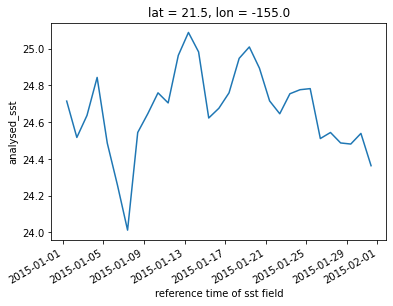

In [14]:
mur_subset_final.isel(lat=350, lon=500).plot()

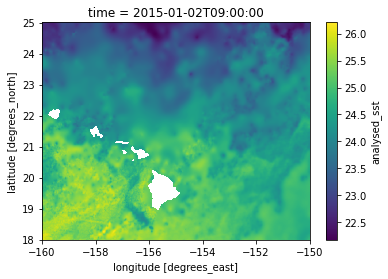

In [15]:
mur_subset_final.isel(time=1).plot()